## Final Project
<b>Tom Borgstadt</b>
<br>BUS 6316S Advanced Topics in Analytics</br>
<br>Summer 2016</br>

### Evaluating solver packages for Portfolio Optimization using ETFs
<b>This notebook:</b>
<br>1. Inputs a list of ETF Ticker Symbols from a .CSV file</br>
<br>2. Retrieves Market Data from Yahoo Finance</br>
<br>3. Generates 12 month time series ETF returns</br>
<br>4. Generates 1500 random portfolios and creates visualization of frontier</br>
<br>5. Various Min/Max testing of portfolio risk/return<br>

<b>Packages utilized:</b>
<br>CVXOPT - Python Software for Convex Optimization</br>
<br>CVXPY - Embedded modeling language for convex optimization problems</br>



In [6]:
# numpy for arrays and matrices
import numpy as np

# pandas dataframe 
import pandas as pd

# pandas data reader for aquiring market data from Yahoo Finance
import pandas_datareader.data as web

# graphing packages
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

debug = 0


#### Use a 12 month daily market data for computing ETF returns

In [7]:
startDate = '2016-06-01'
endDate   = '2017-06-30'

# Input file of the desired ETF ticker symbols
df_etf = pd.read_csv('myetfs.csv')

In [8]:
df_etf

,symbol
0,SPY
1,SH
2,MDY
3,VB
4,VEU
5,AGG
6,TLH
7,RWR
8,GLD


#### Acquire Market Data from Yahoo Finance

In [ ]:
# Initialize a dataframe for market returns
etf_returns_df = pd.DataFrame()

for idx, row in df_etf.iterrows():
    
    print row['symbol']
    # Retrieve the ETF history
    df_sym = pd.DataFrame(web.get_data_yahoo(row['symbol'], start=startDate, end=endDate)['Adj Close'])
 
    # Resample the last value in the Business Month period
    period = 'BM'
    df_sym_tser = df_sym.resample(period).apply(lambda x: x[-1])
    
    # Calculate percent change from period to period
    df_sym_tser_chg = df_sym_tser.pct_change(periods=1)
    df_sym_tser_chg.columns=[row['symbol']]

    etf_returns_df = etf_returns_df.join(df_sym_tser_chg, how='outer')

# Drop any NaN values
etf_returns_df.dropna(axis=0, inplace=True)
print '\nETF Returns: \n', etf_returns_df

# Output dataframe of returns for Excel analysis
etf_returns_df.to_csv('returns.csv')        

# Create a numpy array from the dataframe to be used as matrices later
etf_returns = np.asarray([etf_returns_df[col].values for col in etf_returns_df.columns])

# Capture number of assets
n_assets = len(etf_returns)


#### Correlation Matrix

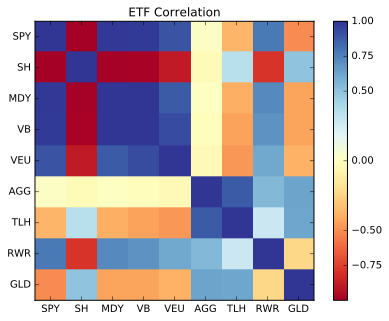

In [40]:
# Calculate correlation using built in pandas correlation function
df_corr = etf_returns_df.corr()
df_corr.to_csv('corr.csv')

# Make plot with vertical (default) colorbar
fig, ax = plt.subplots(figsize=(7,5))
cax = ax.imshow(df_corr, interpolation='nearest', cmap=cm.RdYlBu)
ax.set_title('ETF Correlation')

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[-1,-.75,-.5, 0,.5,.75, 1])

plt.yticks(np.arange(0.0, len(df_corr.index), 1), df_corr.index)
plt.xticks(np.arange(0.0, len(df_corr.columns), 1), df_corr.columns)
plt.savefig("corr.png")
plt.show()

#### Randomly Generate the Portfolio Frontier

In [3]:
k = np.random.rand(5)
k

array([ 0.26117177,  0.28631859,  0.43988757,  0.84640379,  0.92171096])

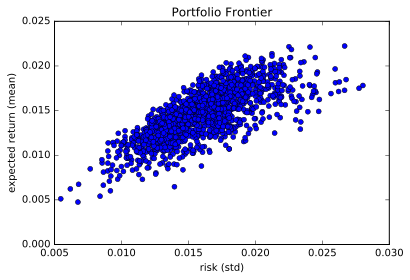

In [41]:
def rand_asset_weights(n):
    # Create n random values that sum to 1
    
    k = np.random.rand(n)
    return k / sum(k)


def portfolio_er(returns, weights):
    # Calculate the Expected Return and Risk for the passed returns
    # If asset weights are not passed, generate random asset weights    
    
    p = np.asmatrix(np.mean(returns, axis=1))  # Asset expected returns (means)
    
    if weights.any():                       # If asset weights passed, use them
        w = np.asmatrix(weights)            
    else:                                   # Otherwise generate random asset weights
        w = np.asmatrix(rand_asset_weights(n_assets))
    
    C = np.asmatrix(np.cov(returns))        # Covariance Matrix
    
    mu = w * p.T                            # Portfolio expected return (ER)
    sigma = np.sqrt(w * C * w.T)            # Portfolio risk (SD)

    if debug == True:
        print 'stock returns (p):\n', p
        print 'stock weights (w):\n', w
        print 'covariance matrix (C):\n', C
        print 'portfolio expected return (mu):\n', mu
        print 'portfolio expected risk (sigma):\n', sigma

    return mu, sigma

# Generate random portfolios
n_portfolios = 1500
means, stds = np.column_stack([
    portfolio_er(etf_returns, np.array([])) 
    for _ in xrange(n_portfolios)
])

# Plot the random portfolios
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('risk (std)')
plt.ylabel('expected return (mean)')
plt.title('Portfolio Frontier')
plt.savefig("cvxopt_ef1.png")
plt.show()

### CVXOPT

Python Software for Convex Optimization

http://cvxopt.org/

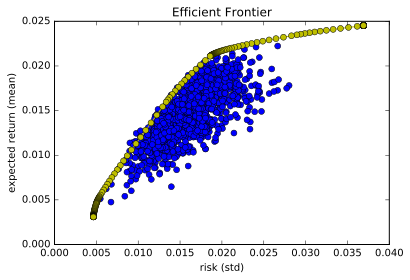

In [42]:
import cvxopt as opt
from cvxopt import blas, solvers, matrix

# Turn off solver progress printing 
solvers.options['show_progress'] = False


def optimal_portfolio(returns, N=200):
    n = len(returns)
    
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)] # Generate list of Expected Returns for E. Frontier
   
    ######### Problem Setup ##################

    P = opt.matrix(np.cov(returns))           # portfolio variance/covariance matrix (required)
    q = opt.matrix(np.mean(returns, axis=1))  # portfolio assets expected returns (required)
    
    ######### Constraint Matrices ############
    
    G = opt.matrix(0.0, (n, n))     # left side of weights constraint equation
    G[::n+1] = -1.0
    h = -opt.matrix(0.05, (n ,1))   # right side, must be invested at least 5% in each ETF

    A = opt.matrix(1.0, (1, n))     # equality constraint Aw = b
    b = opt.matrix(1.0)             # sum(w) = 1
    
    ##########################################
    
    if debug == True:
        print 'P:\n', P
        print 'q:\n', q
        print 'G:\n', G
        print 'h:\n', h
        print 'A:\n', A
        print 'b:\n', b
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*P, -q, G, h, A, b)['x'] for mu in mus]
    
    # Calculate risks and returns for the frontier
    returns = [blas.dot(q, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, P*x)) for x in portfolios]
    
    # Calculate the 2nd degree (quadratic) polynomial of the frontier curve
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])

    # Calculate the optimal portfolio
    wts = solvers.qp(opt.matrix(x1 * P), -q, G, h, A, b)['x']

    if debug == True:
        print 'm1: \n', m1
        print 'x1: \n', x1
    
    return np.asarray(wts), returns, risks

weights, returns, risks = optimal_portfolio(etf_returns)

# Plot the efficient frontier
plt.plot(stds, means, 'o')
plt.xlabel('risk (std)')
plt.ylabel('expected return (mean)')
plt.plot(risks, returns, 'y-o')
plt.title('Efficient Frontier')
plt.savefig("cvxopt_ef2.png")
plt.show()

In [43]:
er, sd = portfolio_er(etf_returns, weights.T)

print '\nOptimal Portfolio:'
print '  Weights: ', weights.T
print '  Expected Return: ', er
print '  Risk:            ', sd


Optimal Portfolio:
  Weights:  [[ 0.05000035  0.05000015  0.05000049  0.05000048  0.0500003   0.05000026
   0.0500003   0.05000053  0.59999712]]
  Expected Return:  [[ 0.02452572]]
  Risk:             [[ 0.03692225]]


### SCIPY

In [76]:
# Setup
w0 = np.asmatrix(rand_asset_weights(n_assets)) # Weights

er = np.asmatrix(np.mean(etf_returns, axis=1))  # Asset expected returns (means)
# w = np.asmatrix(rand_asset_weights(n_assets)) # Weights
var_cov = np.asmatrix(np.cov(etf_returns))      # Covariance Matrix

er_p = w0 * er.T                                 # Portfolio expected return (ER)
sd_p = np.sqrt(w0 * var_cov * w0.T)               # Portfolio risk (SD)

# print w
# print p
# print C
# print er_p
# print sd_p


In [82]:
from scipy.optimize import fmin_slsqp

In [83]:
def er_p(w):
    return(w * er.T)

def ec1(w):
    return 1 - np.sum(w)

In [84]:
optimize.fmin_slsqp(er_p, 
              w0,
              eqcons=[ec1])



Optimization terminated successfully.    (Exit mode 0)
            Current function value: [[-3696723.3406846]]
            Iterations: 18
            Function evaluations: 208
            Gradient evaluations: 18


array([  4340389.45980097,  84689098.85997002,   4880985.62343939,
        19652743.98310816,  62657642.95679057,   7451196.10576817,
       -18527801.79803399, -76073197.67653242, -89071056.51431085])

### CVXPY

http://www.cvxpy.org/

CVXPY is a Python-embedded modeling language for convex optimization problems. It automatically transforms the problem into standard form, calls a solver, and unpacks the results.

In [22]:
from cvxpy import *

N = 100
gamma_vals = np.logspace(-2, 3, num=N)
risk_data = np.zeros(N)
ret_data = np.zeros(N)

######## Problem Setup #########

Sigma = np.array(np.cov(etf_returns))          # portfolio variance/covariance matrix
mu = np.array(np.mean(etf_returns, axis=1))    # portfolio assets expected returns

w = Variable(n_assets)                         # weights variable

gamma = Parameter(sign='positive')

ret = mu.T*w                                   # numpy will handle basic matrix algebra

risk = quad_form(w, Sigma)


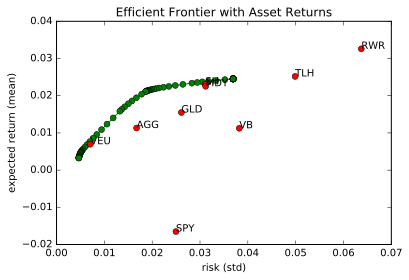

In [23]:
###### Problem 1 - Benchmark Efficient Frontier #############
prob = Problem(Maximize(ret - gamma*risk), 
               [sum_entries(w) == 1, 
                w >= 0.05])

# Calculate a range of values to plot
for i in range(N):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = sqrt(risk).value
    ret_data[i] = ret.value

# Plot long only trade-off curve for n_assets
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-o')

for i in range(n_assets):
    plt.plot(sqrt(Sigma[i,i]).value, mu[i], 'ro')
    plt.annotate(etf_returns_df.columns.tolist()[i-1], xy=(sqrt(Sigma[i,i]).value, mu[i]))
   
plt.xlabel('risk (std)')
plt.ylabel('expected return (mean)')
plt.title('Efficient Frontier with Asset Returns')
plt.savefig("cvxpy_ef1.png")
plt.show()

In [25]:
########## Maximize Return #############
   
prob = Problem(Maximize(ret), 
               [sum_entries(w) == 1, 
                w >= 0.07])
prob.solve()

print '\nOptimal Portfolio to Maximize Return:'
print '  Weights: ', w.value.T
print '  Expected Return: ', ret.value
print '  Risk:            ', sqrt(risk).value



Optimal Portfolio to Maximize Return:
  Weights:  [[ 0.07000001  0.07        0.07000001  0.07000001  0.07        0.07        0.07
   0.07000001  0.43999995]]
  Expected Return:  0.0212951228746
  Risk:             0.0270104579326


In [14]:
########## Minimize Risk #############
   
prob = Problem(Minimize(risk), 
               [sum_entries(w) == 1, 
                w >= 0.05])
prob.solve()

print '\nOptimal Portfolio to Minimize Risk:'
print '  Weights: ', w.value.T
print '  Expected Return: ', ret.value
print '  Risk:            ', sqrt(risk).value


Optimal Portfolio to Minimize Risk:
  Weights:  [[ 0.20682094  0.42022355  0.06443884  0.05004125  0.05846822  0.05000434
   0.05000147  0.05000075  0.05000064]]
  Expected Return:  -0.000120482914737
  Risk:             0.000879377049416


### Troubleshooting CVXOPT

There are a couple of things that you can try:

1) Check how your constraints are scaled and rescale if necessary (see e.g. https://groups.google.com/forum/#!topic/cvxopt/IstFuvQqXtM or https://groups.google.com/forum/#!topic/cvxopt/MeEq5Q1Har0).

2) Change the default tolerances in the options dictionary (see http://cvxopt.org/userguide/coneprog.html#algorithm-parameters).

If these suggestions do not help, I'd be happy to help if you can send me a problem instance.